In [17]:
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

class Robot:
    # Global dictionaries for synchronization
    robot_positions_dict = {}  # Stores positions of all robots
    robot_instances = {}  # Stores robot objects by ID

    def __init__(self, x, y, id):
        self.id = id
        self.active = True
        self.target_x = x
        self.fixed = False  # Determines if the robot is a fixed reference point
        self.case_2_count = None  # Stores active count in case 2

        # Store in global dictionaries
        Robot.robot_positions_dict[self.id] = (x, y)
        Robot.robot_instances[self.id] = self

    def get_position(self):
        """Fetches the robot's current position from the global dictionary."""
        return Robot.robot_positions_dict[self.id]

    def set_target(self, x):
        """Sets a target x-position for movement."""
        self.target_x = x

    def move(self):
        """Moves the robot to its target position and deactivates it."""
        x, y = Robot.robot_positions_dict[self.id]
        if self.target_x != x:
            Robot.robot_positions_dict[self.id] = (self.target_x, y)
        self.active = False  # Robot deactivates after moving

    def set_active(self, status):
        """Sets robot's active state (can be reactivated if needed)."""
        self.active = status

    def is_switched_off(self):
        """Returns True if the robot has moved and is now inactive."""
        return not self.active

    def store_case_2_count(self, active_robots):
        """Stores the total count of active Case 2 robots, excluding fixed robots."""
        self.case_2_count = len([robot for robot in active_robots if not robot.fixed])


In [18]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from collections import defaultdict

def plot_robots(robots, R, title):
    """Plot robots inside a circular boundary, coloring based on y-line grouping."""
    fig, ax = plt.subplots(figsize=(6, 6))

    # Draw the circular boundary
    circle = plt.Circle((0, 0), R, color='b', fill=False, linestyle='dotted')
    ax.add_patch(circle)

    # Draw X = 0 reference line
    ax.axvline(0, color='black', linestyle='--')

    # Step 1: Group robots by rounded y-coordinates
    y_groups = defaultdict(list)
    for robot in robots:
        _, y = Robot.robot_positions_dict[robot.id]
        y_key = round(y, 1)  # Precision level; can be tuned
        y_groups[y_key].append(robot)

    # Step 2: Color and plot each robot
    for y_key, group in y_groups.items():
        color = 'green' if len(group) > 1 else 'red'
        for robot in group:
            x, y = Robot.robot_positions_dict[robot.id]
            x_rounded, y_rounded = round(x, 2), round(y, 2)

            # Plot robot as a filled circle
            robot_circle = Circle((x, y), 0.5, color=color, fill=True)
            ax.add_patch(robot_circle)

            # Annotate with coordinates
            ax.text(x_rounded + 0.3, y_rounded, f'({x_rounded},{y_rounded})', fontsize=8, color='black')

    # Final formatting
    ax.set_xlim(-R, R)
    ax.set_ylim(-R, R)
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_title(title)
    ax.set_aspect('equal')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [19]:
def categorize_robots(robots):
    horizontal_lines = {}  # Dictionary to group robots by y-coordinate
    case_1 = {}  # Stores Case 1 robots grouped by y-coordinate
    case_2 = []  # Stores Case 2 robots (exactly one per horizontal line)

    # Group robots by y-coordinates using global robot dictionary
    for robot in robots:
        x, y = Robot.robot_positions_dict[robot.id]  # Fetch position from global dictionary
        if y not in horizontal_lines:
            horizontal_lines[y] = []
        horizontal_lines[y].append(robot)

    # Categorize robots into Case 1 and Case 2
    for y, robots_on_line in horizontal_lines.items():
        if len(robots_on_line) > 1:
            case_1[y] = robots_on_line  # Group Case 1 robots by their y-coordinate
        else:
            case_2.extend(robots_on_line)  # Single robot on this line → Case 2

    # Print Case 1 robots
    print("Case 1 Robots (Multiple robots on the same horizontal line):")
    for y, robots_on_line in case_1.items():
        print(f"y = {y}: {robots_on_line}")

    # Print Case 2 robots
    print("\nCase 2 Robots (Single robot on a horizontal line):")
    for robot in case_2:
        print(robot)

    return case_1, case_2, horizontal_lines  # Return the categorization results


In [20]:
# Function to adjust robots to the right side of x = 0 with correct equal distribution
def rightBalance(robots, radius, y):
    leftRobots = []
    rightRobots = []

    for robot in robots:
        x, _ = Robot.robot_positions_dict[robot.id]  # Fetch position from global dictionary
        if x < 0:
            leftRobots.append(robot)
        else:
            rightRobots.append(robot)

    extraRobots = (len(rightRobots) - len(leftRobots) + 1) // 2
    maxAllowedX = (radius**2 - y**2) ** 0.5  # Boundary constraint

    maxPos = -extraRobots + 1 - len(leftRobots) if len(robots) % 2 == 1 else -extraRobots + 0.5 - len(leftRobots)
    newPos = -extraRobots + 1 if len(robots) % 2 == 1 else -extraRobots + 0.5

    for i in range(len(leftRobots)):
        x, _ = Robot.robot_positions_dict[leftRobots[i].id]
        if x > maxPos:
            leftRobots[i].set_target(max(maxPos, -maxAllowedX))  # Ensure within boundary
        maxPos += 1

    for i in range(min(extraRobots, len(rightRobots))):
        rightRobots[i].set_target(min(newPos, maxAllowedX))  # Ensure within boundary
        newPos += 1

    # Apply movement
    for robot in leftRobots + rightRobots:
        robot.move()


# Function to adjust robots to the left side of x = 0
def leftBalance(robots, radius, y):
    leftRobots = []
    rightRobots = []

    for robot in robots:
        x, _ = Robot.robot_positions_dict[robot.id]  # Fetch position from global dictionary
        if x <= 0:
            leftRobots.append(robot)
        else:
            rightRobots.append(robot)

    extraRobots = (len(leftRobots) - len(rightRobots) + 1) // 2
    maxAllowedX = (radius**2 - y**2) ** 0.5  # Boundary constraint

    minPos = extraRobots - 1 + len(rightRobots) if len(robots) % 2 == 1 else extraRobots - 0.5 + len(rightRobots)
    newPos = extraRobots - 1 if len(robots) % 2 == 1 else extraRobots - 0.5

    for i in range(len(rightRobots) - 1, -1, -1):
        x, _ = Robot.robot_positions_dict[rightRobots[i].id]
        if x < minPos:
            rightRobots[i].set_target(min(minPos, maxAllowedX))  # Ensure within boundary
        minPos -= 1

    for i in range(len(leftRobots) - 1, max(len(leftRobots) - extraRobots, 0) - 1, -1):
        leftRobots[i].set_target(max(newPos, -maxAllowedX))  # Ensure within boundary
        newPos -= 1

    # Apply movement
    for robot in leftRobots + rightRobots:
        robot.move()


# Function to balance robots across x = 0
def case1_balance(robots, radius, y):
    robots.sort(key=lambda robot: Robot.robot_positions_dict[robot.id][0])  # Sort based on x-coordinates

    leftCount = sum(1 for robot in robots if Robot.robot_positions_dict[robot.id][0] < 0)
    rightCount = sum(1 for robot in robots if Robot.robot_positions_dict[robot.id][0] > 0)

    if leftCount > rightCount:
        leftBalance(robots, radius, y)
    elif rightCount > leftCount:
        rightBalance(robots, radius, y)


def handle_case_1(original_robots , case_1, radius, step):
    """ Applies equal distribution for Case 1 robots while keeping global synchronization """
    for y, robots in case_1.items():
        case1_balance(robots, radius, y)  # Balance robots on each horizontal line
        title = f"Step {step}"
        plot_robots(original_robots, radius, title)
        step = step + 1

    # Print Case 1 robots
    print("Case 1 Robots (Multiple robots on the same horizontal line):")
    for y, robots_on_line in case_1.items():
        print(f"y = {y}: {[Robot.robot_positions_dict[robot.id] for robot in robots_on_line]}")

    return case_1


In [21]:
import random

def handle_case_2(original_robots, case_2, R, step):
    """ Handles density-based balancing for Case 2 robots using global synchronization """

    # Identify fixed robots at topmost and bottommost positions
    fixed_positions = {(0, R), (0, -R)}
    fixed_robots = [robot for robot in case_2 if Robot.robot_positions_dict[robot.id] in fixed_positions]

    # Remaining active robots (excluding fixed robots)
    active_robots = [robot for robot in case_2 if Robot.robot_positions_dict[robot.id] not in fixed_positions]

    # Initial count determination (excluding fixed robots)
    initial_count = len(active_robots)
    left_count = sum(1 for robot in active_robots if Robot.robot_positions_dict[robot.id][0] < 0)
    right_count = sum(1 for robot in active_robots if Robot.robot_positions_dict[robot.id][0] > 0)

    # Each active robot stores the total count for reference
    for robot in active_robots:
        robot.store_case_2_count(active_robots)

    # Sort active robots by y-coordinate (ascending)
    active_robots.sort(key=lambda r: Robot.robot_positions_dict[r.id][1])

    # Density-Based Balancing Process (iterative)
    while active_robots:
        # Pop first robot from the list (topmost in sorted order)
        robot = active_robots.pop(0)

        x, y = Robot.robot_positions_dict[robot.id]

        # Ensure move is within circular boundary
        max_x = (R**2 - y**2) ** 0.5

                # If this is the last active robot, determine its move
        if len(active_robots) == 0:
            if initial_count % 2 == 1:
                target_x = 0  # Move to the center
            else:
                if left_count < right_count:
                    target_x = -max_x / 2  # Move to less dense side
                elif left_count > right_count:
                    target_x = max_x / 2
                else:
                    target_x = x  # Equal density — move to center
        else:
            # Normal density-based balancing
            if left_count == right_count:
                target_x = x  # No movement if density is equal
            elif left_count < right_count and x >= 0:
                target_x = -max_x / 2  # Move only if on the wrong side
            elif right_count < left_count and x <= 0:
                target_x = max_x / 2
            else:
                target_x = x  # Already on correct side; no need to move


        # Only update counts if the robot actually moves to a different side
        if target_x != x:
            if x < 0:
                left_count -= 1  # The robot is leaving the left side
            elif x > 0:
                right_count -= 1  # The robot is leaving the right side

            if target_x < 0:
                left_count += 1  # The robot is moving to the left side
            elif target_x > 0:
                right_count += 1  # The robot is moving to the right side

        # Move robot and update global position dictionary
        robot.set_target(target_x)
        robot.move()
        Robot.robot_positions_dict[robot.id] = (target_x, y)  # Update the global position dictionary

        # Switch the robot off after it has moved
        robot.set_active(False)  # Assume `set_active(False)` will deactivate the robot
        title = f"Step {step}"
        plot_robots(original_robots, radius, title)
        step += 1

    # Print Case 2 robots after balancing
    print("Case 2 Robots (Each horizontal line has exactly one robot):")
    for robot in case_2:
        print(f"Robot at {Robot.robot_positions_dict[robot.id]}")


In [22]:
def terminate_if_all_robots_switched_off():
    """ Terminates if all robots are switched off using global sync dictionary """
    all_switched_off = all(robot.is_switched_off() for robot in Robot.robot_instances.values())
    if all_switched_off:
        print("All robots have been switched off. Terminating.")


In [23]:
def balance_robots(robots, radius, step):

    # Step 1: Categorization
    case_1, case_2, horizontal_lines = categorize_robots(robots)

    # Step 2: Handle Case 1 (Equal Distribution)
    handle_case_1(robots , case_1 , radius, step)

    # Step 3: Handle Case 2 (Density-Based Balancing)
    handle_case_2(robots, case_2, radius, step)

    # Step 4: Termination check
    terminate_if_all_robots_switched_off()


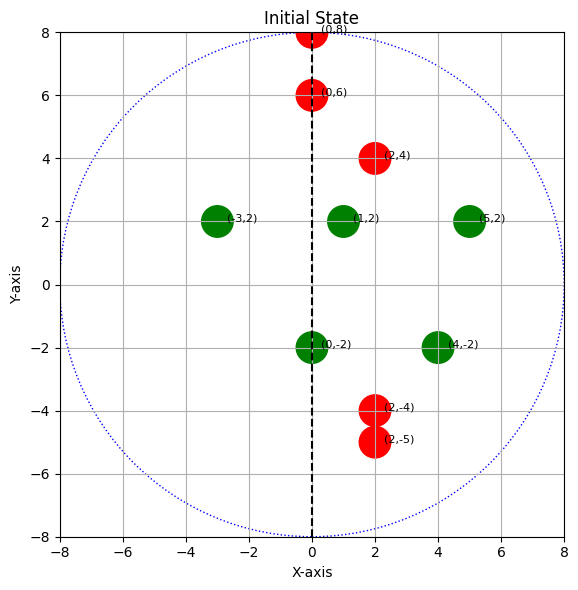

Case 1 Robots (Multiple robots on the same horizontal line):
y = 2: [<__main__.Robot object at 0x7af0245178d0>, <__main__.Robot object at 0x7af024516ed0>, <__main__.Robot object at 0x7af024516ad0>]
y = -2: [<__main__.Robot object at 0x7af024515750>, <__main__.Robot object at 0x7af03c525890>]

Case 2 Robots (Single robot on a horizontal line):


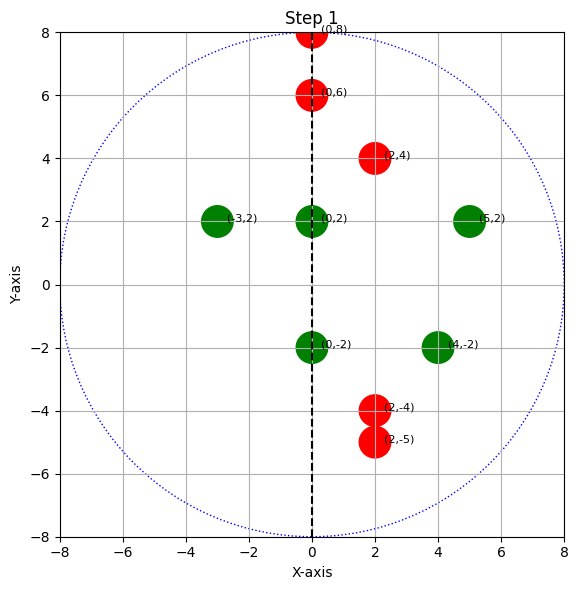

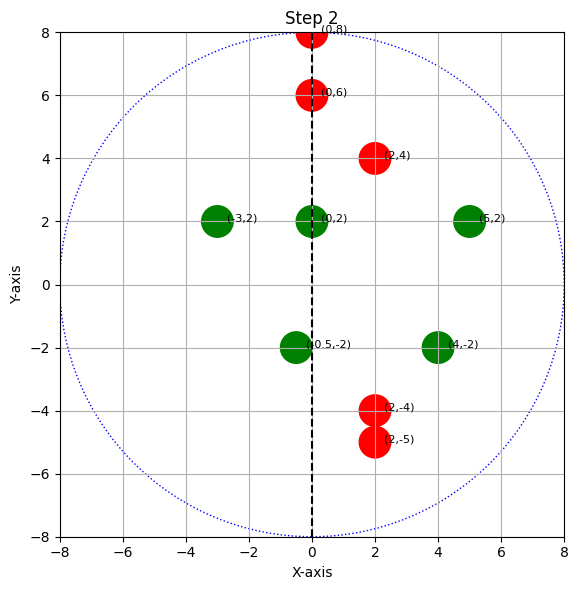

Case 1 Robots (Multiple robots on the same horizontal line):
y = 2: [(-3, 2), (0, 2), (5, 2)]
y = -2: [(-0.5, -2), (4, -2)]


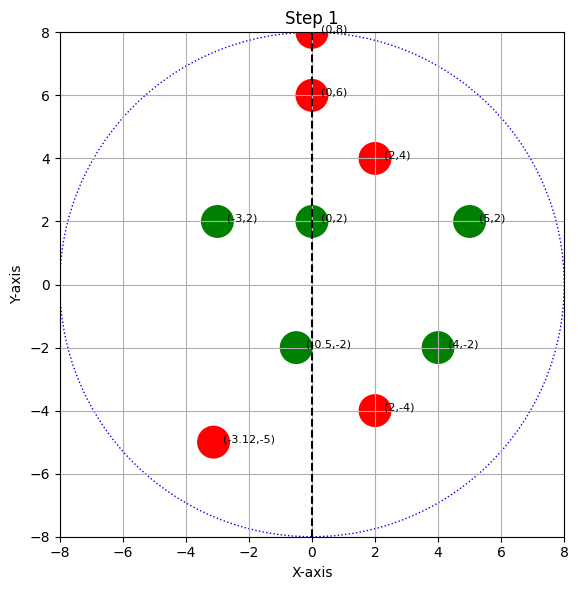

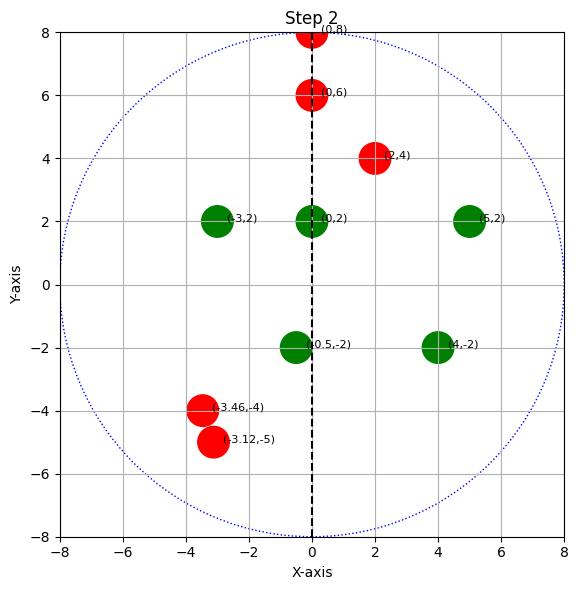

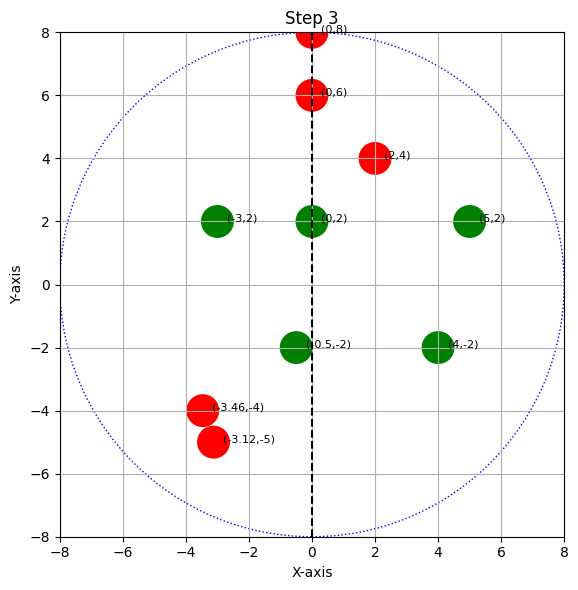

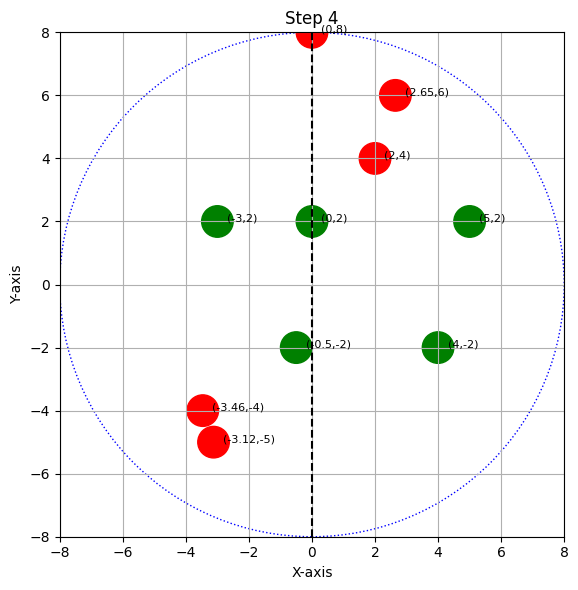

Case 2 Robots (Each horizontal line has exactly one robot):
Robot at (0, 8)
Robot at (2.6457513110645907, 6)
Robot at (2, 4)
Robot at (-3.4641016151377544, -4)
Robot at (-3.122498999199199, -5)


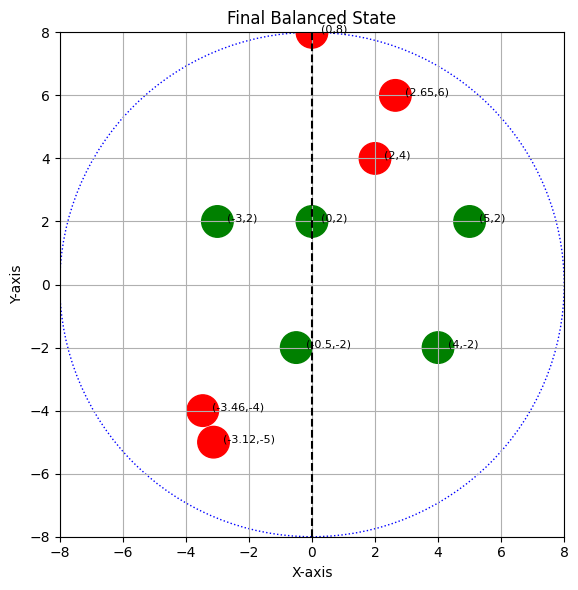

In [24]:
# Example Input
robot_positions = [(0,8), (0,6),(2 ,4), (-3,2), (1,2), (5,2), (0,-2), (4,-2), (2,-4), (2,-5)]
radius = 8
robots = [Robot(x, y, id) for id, (x, y) in enumerate(robot_positions, start=1)]

# Plot Initial State
plot_robots(robots, radius, "Initial State")
step = 1
# Execute balancing algorithm
balance_robots(robots, radius, step)

# Plot Final State
plot_robots(robots, radius, "Final Balanced State")